**install and import dependencies**

In [ ]:
!pip install easyocr
!pip install imutils


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

In [4]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np
import imutils
import easyocr

**Read in the image , gray scale and blur**

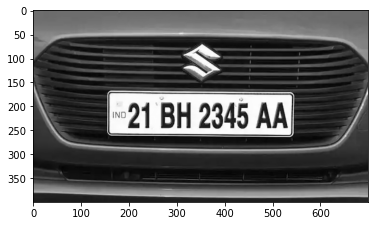

In [43]:
img = cv2.imread('1004194-bh-plate.webp') ## WE ASRE READIMNG THE IMPUT IMAGE 
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) ##CONVERING THE COLORED IMAGE TO GRAY SCALE  WE USIE BGR2GRAY BECAUSE WHEN CV2 READS THE IMAGE IT READS IN BGR FORMAT
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB)) #

**apply the filter and find edges for localization**

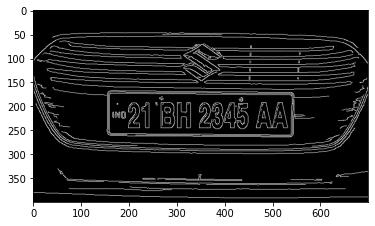

In [44]:
#WE APPLY FILTERRING TO REMOVE NOISE FROM THE IMAGE TO GET PERFECT EDGES
bfilter = cv2.bilateralFilter(gray,11,17,17) #noise reduction // the three propertied help us to change how intensely we are needed our noise reduction to be 
edged = cv2.Canny(bfilter,30,200) #edge detection //
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

**Find contours and apply mask**

In [45]:
keypoints = cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) ## this helps in ginding the contours and RETR_TREE is used to return the output in the form of tree and CHAIN_APPROX_SIMPLE is used to approx what the contour look like 
contours = imutils.grab_contours(keypoints) ##
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  ## we are sorting and returning top 10 countours according to area

In [46]:
##next we will loop those contous and look weather its a rectangle or not
location = None
for contour in  contours:
    approx = cv2.approxPolyDP(contour , 10,True)
    if len(approx) == 4:
        location = approx
        break

In [47]:
location ## this is the location of our number plate might actually be 

array([[[159, 176]],

       [[537, 176]],

       [[539, 257]],

       [[163, 257]]], dtype=int32)

In [48]:
##mask to show the number plate

mask = np.zeros(gray.shape , np.uint8) ## created the mask of same shape of original gray image
new_image = cv2.drawContours(mask,[location] , 0,225,-1) ## e draw the contour on the temporary mask
new_image = cv2.bitwise_and(img,img,mask=mask) ## overlaying the mask on the image using bitwise and operator


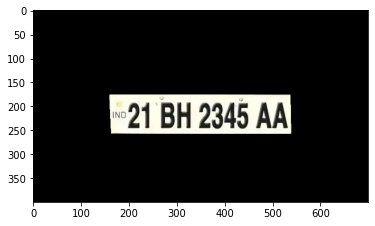

In [49]:
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

In [50]:
## isolate the number plate 
(x,y) = np.where(mask == 225)
(x1,y1) = (np.min(x) , np.min(y))
(x2,y2) = (np.max(x) , np.max(y))
cropped_image = gray[x1:x2+1 , y1:y2+1]

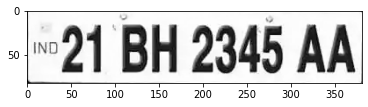

In [51]:
plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))

**Use easy ocr to read text**

In [52]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[2, 30], [40, 30], [40, 54], [2, 54]], 'IND', 0.861893301516676),
 ([[28, 6], [381, 6], [381, 80], [28, 80]],
  '21 BH 2345 AA',
  0.9172399101483343)]

**Render result**

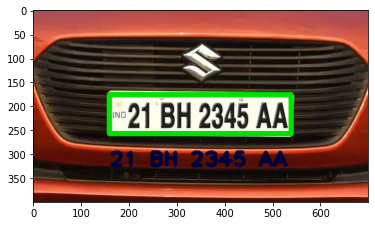

In [56]:
text = result[1][-2]
font = cv2.FONT_HERSHEY_PLAIN
res = cv2.putText(img , text = text , org=(approx[0][0][0],approx[1][0][1]+150), fontFace = font , fontScale = 3,color=(60.225,0),thickness=5,lineType=cv2.LINE_AA)
res = cv2.rectangle(img , tuple(approx[0][0]) , tuple(approx[2][0]), (0,225,0) , 10)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))